# Natural language processing with disaster tweets

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.\

Submissions are evaluated using F1 between the predicted and expected answers.

## Importing libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/submission-file/submission (2).csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
!pip install datasets==2.16.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.12.2
    Uninstalling fsspec-2023.12.2:
      Successfully uninstalled fsspec-2023.12.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.1.0
    Uninstalling datasets-2.1.0:
      Successfully uninstalled datasets-2.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 require

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Scikit Learn
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score

#Tensorflow / Keras
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from keras.callbacks import EarlyStopping

#Hugging Face Transformers
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from datasets import load_dataset


2024-02-02 09:46:11.739373: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 09:46:11.739484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 09:46:12.023160: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading data

In [4]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
sample_submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

## Exploratory data analysis

In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
train_df['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [8]:
train_df['location'].unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

<Axes: xlabel='target', ylabel='count'>

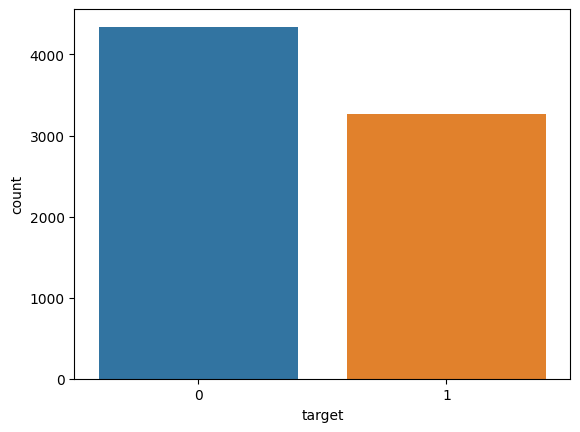

In [9]:
sns.countplot(data=train_df, x='target')

In [10]:
keyword_counts = train_df.groupby('keyword')['id'].count().sort_values(ascending=False).reset_index()
keyword_counts.columns = ['keyword', 'count']
keyword_counts

,keyword,count
0,fatalities,45
1,armageddon,42
2,deluge,42
3,harm,41
4,damage,41
...,...,...
216,forest%20fire,19
217,epicentre,12
218,threat,11
219,inundation,10


In [11]:
train_df['text_length'] = train_df['text'].str.len()
train_df_sorted = train_df.sort_values(by='text_length', ascending=False)
train_df_sorted.head()

,id,keyword,location,text,target,text_length
1270,1832,burned,NaN,when you're taking a shower and someone flushe...,0,157
4801,6833,loud%20bang,london essex england uk,It's was about 2:30 in the morning&amp;I went ...,0,152
614,885,bioterrorism,NaN,@CAgov If 90BLKs&amp;8WHTs colluded 2 take WHT...,1,151
635,919,bioterrorism,NaN,@cspanwj If 90BLKs&amp;8WHTs colluded 2 take W...,1,150
633,915,bioterrorism,NaN,@HowardU If 90BLKs&amp;8WHTs colluded 2 take W...,1,150


## Preparing the dataset

In [12]:
train_dataset = load_dataset("csv", data_files='/kaggle/input/nlp-getting-started/train.csv')
train_dataset

Generating train split: 0 examples [00:00, ? examples/s]

/opt/conda/lib/python3.10/site-packages/datasets/download/streaming_download_manager.py:778: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'target'],
        num_rows: 7613
    })
})

In [13]:
train_dataset_clean = train_dataset["train"].train_test_split(train_size=0.8, seed=42)

## Model checkpoint

In [14]:
# distilbert-base-uncased-finetuned-sst-2-english
# DunnBC22/distilbert-base-uncased-Tweet_About_Disaster_Or_Not

checkpoint = "DunnBC22/distilbert-base-uncased-Tweet_About_Disaster_Or_Not"

## Tokenize the dataset

In [15]:
batch_size = 16

In [16]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [17]:
def tokenize_and_split(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=157,
        return_overflowing_tokens=False,
    )

In [18]:
tokenized_train_dataset = train_dataset_clean.map(tokenize_and_split, batched=True)

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

In [19]:
train_dataset_clean

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'target'],
        num_rows: 6090
    })
    test: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'target'],
        num_rows: 1523
    })
})

In [20]:
tokenized_train_dataset['train']

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'target', 'input_ids', 'attention_mask'],
    num_rows: 6090
})

In [21]:
tokenized_train_dataset['test']

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'target', 'input_ids', 'attention_mask'],
    num_rows: 1523
})

In [22]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [23]:
tf_train_dataset = tokenized_train_dataset["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["target"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=batch_size,
)

tf_test_dataset = tokenized_train_dataset["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["target"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=batch_size,
)

/opt/conda/lib/python3.10/site-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


## Model fine-tuning

In [24]:
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2, from_pt=True)

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [25]:
num_epochs = 5

In [26]:
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.

num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps)

opt = Adam(learning_rate=lr_scheduler)
loss = SparseCategoricalCrossentropy(from_logits=True)

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto', restore_best_weights=True)

In [27]:
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [28]:
model.fit(tf_train_dataset, validation_data=tf_test_dataset, epochs=num_epochs, callbacks=[es])

Epoch 1/5


I0000 00:00:1706867223.911487      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


381/381 [==============================] - 74s 130ms/step - loss: 0.4355 - accuracy: 0.8171 - val_loss: 0.3936 - val_accuracy: 0.8345
Epoch 2/5
381/381 [==============================] - 40s 106ms/step - loss: 0.2902 - accuracy: 0.8895 - val_loss: 0.4879 - val_accuracy: 0.8024
Epoch 3/5
381/381 [==============================] - 43s 112ms/step - loss: 0.1837 - accuracy: 0.9340 - val_loss: 0.5265 - val_accuracy: 0.8089
Epoch 3: early stopping


In [29]:
preds = model.predict(tf_test_dataset)["logits"]

96/96 [==============================] - 5s 35ms/step


In [30]:
y_pred = np.argmax(preds, axis=1)
print(preds.shape, y_pred.shape)

(1523, 2) (1523,)


In [31]:
y_pred

array([1, 0, 1, ..., 0, 1, 0])

In [32]:
y_true = np.concatenate([y for x, y in tf_test_dataset], axis=0)
# https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset

## Evaluation

In [33]:
def evaluate_model(y_true, y_pred):
  print(ConfusionMatrixDisplay.from_predictions(y_true, y_pred))
  print(classification_report(y_true, y_pred))
  print('F1 score:', f1_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       872
           1       0.84      0.75      0.80       651

    accuracy                           0.83      1523
   macro avg       0.84      0.82      0.83      1523
weighted avg       0.84      0.83      0.83      1523

F1 score: 0.7954545454545455


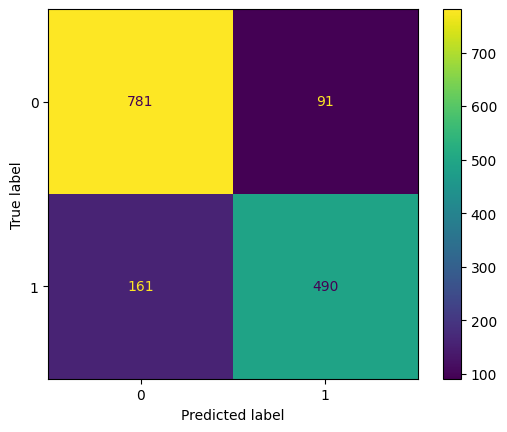

In [34]:
evaluate_model(y_true=y_true, y_pred=y_pred)

In [35]:
model.save_pretrained("/content/model_tuned")

In [36]:
# Load your model
#model = MyModel.from_pretrained("path/to/model")

## Final predictions and submissions

In [37]:
tokenized_test_dataset = load_dataset("csv", data_files='/kaggle/input/nlp-getting-started/test.csv').map(tokenize_and_split, batched=True)
tokenized_test_dataset

Generating train split: 0 examples [00:00, ? examples/s]

/opt/conda/lib/python3.10/site-packages/datasets/download/streaming_download_manager.py:778: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'input_ids', 'attention_mask'],
        num_rows: 3263
    })
})

In [38]:
tf_final_dataset = tokenized_test_dataset["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    #label_cols=["target"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=batch_size,
)

In [39]:
final_preds = model.predict(tf_final_dataset)["logits"]

204/204 [==============================] - 8s 34ms/step


In [40]:
final_class_preds = np.argmax(final_preds, axis=1)
final_class_preds

array([1, 1, 1, ..., 1, 1, 1])

In [41]:
sample_submission["target"] = final_class_preds

In [42]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB


In [43]:
sample_submission.to_csv("submission.csv", index=False)

The kaggle score is 0.83